In [53]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import random
from datetime import datetime


# Track total runtime
_start_time = datetime.now()

# Set the style & colors for the plots
sns.set_style('darkgrid')
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Control randomness
random.seed(1)

Define Prior

In [62]:
# Define Prior odds
prior_odds = 1

In [55]:
def plot_beta_distribution(T_alpha, T_beta, C_alpha, C_beta):
    # Generate values between 0 and 1 (these are the possible values of a Beta distribution)
    x = np.linspace(0, 1, 1000)

    # Calculate the value of the pdf for each x value
    y_C = stats.beta.pdf(x, C_alpha, C_beta)
    y_T = stats.beta.pdf(x, T_alpha, T_beta)

    # Plot
    plt.plot(x, y_C, label=f'Control: α={C_alpha}, β={C_beta}')
    plt.plot(x, y_T, label=f'Treatment: α={T_alpha}, β={T_beta}')
    plt.title('Beta Distribution')
    plt.xlabel('x')
    plt.ylabel('pdf(x)')
    plt.legend()
    plt.grid(True)
    plt.show()


using helper function


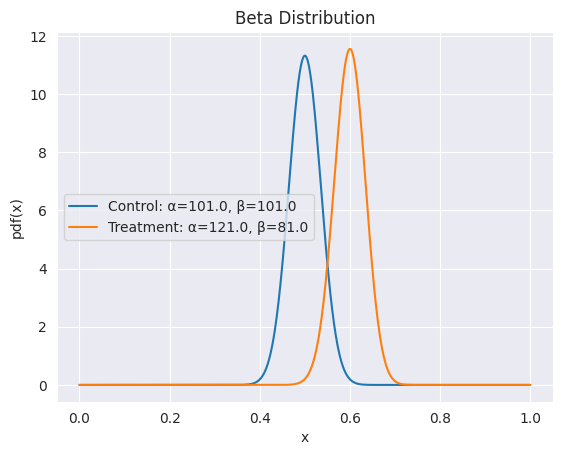

In [56]:
# # Define Prior parameters
# T_prior = {"alpha": 500, "beta": 100}
# C_prior = {"alpha": 100, "beta": 100}

# # Plot priors
# plot_beta_distribution(T_prior["alpha"], T_prior["beta"], C_prior["alpha"], C_prior["beta"])

# Help function with determining alpha & beta
def beta_helper(prior_prob, weight):
    # Sample from Beta distribution: B(weight(prior belief) + 1, weight(1 - prior belief) + 1)
    a = round(prior_prob, 1) * weight + 1
    b = (1 - round(prior_prob, 1)) * weight + 1
    return a, b

# Mean, weight
C_prior["alpha"], C_prior["beta"] = beta_helper(0.5, 200)
T_prior["alpha"], T_prior["beta"] = beta_helper(0.55, 200)

print("using helper function")
plot_beta_distribution(T_prior["alpha"], T_prior["beta"], C_prior["alpha"], C_prior["beta"])

DGP

In [57]:
# Define Control & Treatment DGP (Bernoulli distributed)
C = {"n": 100000, "true_prob": 0.5}
T = {"n": 100000, "true_prob": 0.55}

In [58]:
def get_bernoulli_sample(mean, n):
    # Sample bernoulli distribution with relevant metrics
    samples = [1 if random.random() < mean else 0 for _ in range(n)]
    converted = sum(samples)
    mean = converted/n

    return samples, converted, mean

C["sample"], C["converted"], C["sample_conversion_rate"] = get_bernoulli_sample(mean = C["true_prob"], n = C["n"])
T["sample"], T["converted"], T["sample_conversion_rate"] = get_bernoulli_sample(mean = T["true_prob"], n = T["n"])

# visualise data structre
print(f"Control: {C['sample'][:10]}, Conversion_Rate = {C['sample_conversion_rate']} (true = {C['true_prob']}) \nTreatment: {T['sample'][:10]}, Conversion_Rate = {T['sample_conversion_rate']} (true = {T['true_prob']})")


Control: [1, 0, 0, 1, 1, 1, 0, 0, 1, 1], Conversion_Rate = 0.5004 (true = 0.5) 
Treatment: [1, 0, 1, 1, 1, 1, 1, 1, 1, 1], Conversion_Rate = 0.54892 (true = 0.55)


Marginal Likelihood / Evidence

In [59]:
# Wrong, I think
def marginal_likelihood(prior_alpha, prior_beta, converted, n):
    # Beta distribution because prior Beta distribution is conjugate
    beta_posterior = stats.beta(prior_alpha + converted, prior_beta + (n - converted))
    samples = beta_posterior.rvs(size = 100_000)
    return np.mean(samples)

T_ml = marginal_likelihood(T_prior["alpha"], T_prior["beta"], T["converted"], T["n"])
C_ml = marginal_likelihood(C_prior["alpha"], C_prior["beta"], C["converted"], C["n"])

bayes_factor = T_ml / C_ml
bayes_factor

1.0971666505520679

In [60]:
import numpy as np
from scipy.special import gammaln

def marginal_likelihood_log(alpha, beta, n, k):
    """
    Compute the log of marginal likelihood using Beta prior and Binomial likelihood.

    Parameters:
    - alpha, beta: parameters of the Beta prior
    - n: number of trials in the binomial data
    - k: number of successes in the binomial data

    Returns:
    - Log of the marginal likelihood
    """

    log_comb = gammaln(n+1) - gammaln(k+1) - gammaln(n-k+1)
    log_beta1 = gammaln(k + alpha) + gammaln(n - k + beta) - gammaln(n + alpha + beta)
    log_beta2 = gammaln(alpha) + gammaln(beta) - gammaln(alpha + beta)

    log_result = log_comb + log_beta1 - log_beta2
    return np.exp(log_result)

ml_T = marginal_likelihood_log(T_prior["alpha"], T_prior["beta"], T["n"], T["converted"])
ml_C = marginal_likelihood_log(C_prior["alpha"], C_prior["beta"], C["n"], C["converted"])

bayes_factor = ml_T / ml_C
print(bayes_factor)

0.35333740832565014


In [61]:
import numpy as np
from scipy.special import gammaln

def marginal_likelihood_log(alpha, beta, n, k):
    """
    Compute the log of marginal likelihood using Beta prior and Binomial likelihood.

    Parameters:
    - alpha, beta: parameters of the Beta prior
    - n: number of trials in the binomial data
    - k: number of successes in the binomial data

    Returns:
    - Log of the marginal likelihood
    """

    log_comb = gammaln(n+1) - gammaln(k+1) - gammaln(n-k+1)
    log_beta1 = gammaln(k + alpha) + gammaln(n - k + beta) - gammaln(n + alpha + beta)
    log_beta2 = gammaln(alpha) + gammaln(beta) - gammaln(alpha + beta)

    log_result = log_comb + log_beta1 - log_beta2
    return np.exp(log_result)

ml_TH0 = marginal_likelihood_log(C_prior["alpha"], C_prior["beta"], C["n"], C["converted"])
ml_TH1 = marginal_likelihood_log(C_prior["alpha"], C_prior["beta"], T["n"], T["converted"])

bayes_factor = ml_TH1 / ml_TH0
print(bayes_factor)

0.3829443844578533


Regular: Explodes due to large n

In [64]:
from math import comb
from scipy.special import beta as beta_function

def marginal_likelihood(alpha, beta, n, k):
    """
    Compute the marginal likelihood using Beta prior and Binomial likelihood.

    Parameters:
    - alpha, beta: parameters of the Beta prior
    - n: number of trials in the binomial data
    - k: number of successes in the binomial data

    Returns:
    - Marginal likelihood
    """

    return comb(n, k) * beta_function(k + alpha, n - k + beta) / beta_function(alpha, beta)

ml_T = marginal_likelihood(T_prior["alpha"], T_prior["beta"], T["n"], T["converted"])

OverflowError: ignored

In [63]:
post_odds = prior_odds * bayes_factor